In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

class Neural_Network:
    def __init__(self, input, output, hidden=None) -> None:
        self.input = input
        self.output = output
        self.hidden = hidden

        self.W = []
        self.b = []

        if self.hidden != None:
            self.W.append(np.random.randn(input, hidden[0]))
            self.b.append(np.zeros((1, hidden[0])))

            for i in range(len(hidden)-1):
                self.W.append(np.random.randn(self.hidden[i], self.hidden[i+1]))
                self.b.append(np.zeros((1, self.hidden[i+1])))

            self.W.append(np.random.randn(hidden[-1], output))
            self.b.append(np.zeros(output))
        else:
            self.W.append(np.random.randn(input, output))
            self.b.append(np.zeros(output))

        for i in range(len(self.W)):
            print(f'W{i+1}: {self.W[i].shape}, b{i+1}: {self.b[i].shape}')

    def fit(self, X, Y, epoch, learning_rate, batch_size):
        self.m = len(X)
        self.loss_hist = []
        self.acc_hist = []

        begin = time.time()
        for i in range(1, epoch+1):

            self.build_layer(X)
            if self.output == 1:
                Error = self.binary_cross_entropy(Y, self.A[-1])
                Accuarcy = self.logistic_accuracy(Y, self.A[-1])
                self.loss_hist.append(Error)
                self.acc_hist.append(Accuarcy)
            else:
                Error = self.cross_entropy(Y, self.A[-1])
                Accuarcy = self.softmax_accuracy(Y, self.A[-1])
                self.loss_hist.append(Error)
                self.acc_hist.append(Accuarcy)

            for batch_size_i in range(self.m//batch_size):
                self.loss = []
                
                start_i = batch_size_i*batch_size
                end_i = batch_size_i*batch_size+batch_size

                X_batch = X[start_i:end_i,]
                Y_batch = Y[start_i:end_i,]

                self.build_layer(X_batch)

                # --------------------------------
                # build_layer한 A를 이용하여 가중치 업데이트

                self.loss.append(self.A[-1]-Y_batch)

                for _ in reversed(range(1, len(self.A)-1)):
                    dW = (1/batch_size) * np.dot(self.A[_].T, self.loss[-1])
                    self.W[_] = self.W[_] - learning_rate * dW

                    db = (1/batch_size) * np.sum(self.loss[-1], axis=0)
                    self.b[_] = self.b[_] - learning_rate * db

                    loss = self.A[_] * (1 - self.A[_]) * np.dot(self.loss[-1], self.W[_].T)
                    self.loss.append(loss)

                dW = (1/batch_size) * np.dot(self.A[0].T, self.loss[-1])
                self.W[0] = self.W[0] - learning_rate * dW

                db = (1/batch_size) * np.sum(self.loss[-1], axis=0)
                self.b[0] = self.b[0] - learning_rate * db

                # ----------------------------------

            end = time.time()
            print(f'Epoch: {i:5}/{epoch}, loss: {Error.item():f}, accuarcy: {Accuarcy.item():f} - {end-begin:f}s')
            begin = time.time()

    def build_layer(self, X):
        self.A = []
        self.A.append(X) # A의 첫번째 데이터는 X
        for i in range(len(self.W)):

            if i+1 == len(self.W):
                if self.output == 1:
                    self.A.append(self.sigmoid(np.dot(self.A[i], self.W[i])+self.b[i]))
                else:
                    self.A.append(self.softmax(np.dot(self.A[i], self.W[i])+self.b[i]))
            else:
                self.A.append(self.sigmoid(np.dot(self.A[i], self.W[i])+self.b[i]))  

    def evaluate(self, X, Y):
        self.build_layer(X)

        if self.output == 1:
            return self.binary_cross_entropy(Y, self.A[-1]), self.logistic_accuracy(Y, self.A[-1])
        else:
            return self.cross_entropy(Y, self.A[-1]), self.softmax_accuracy(Y, self.A[-1])
    
    def plot(self):
        plt.plot(self.loss_hist, label='loss')
        plt.plot(self.acc_hist, label='accuracy')
        plt.legend()
        plt.show()

    def cross_entropy(self, y_true, y_pred):
        return -(1/len(y_true)) * np.sum(np.sum(y_true*np.log(y_pred+1e-7), axis=1), axis=0)

    def softmax_accuracy(self, y_true, y_pred):
        return (1/len(y_true)) * np.sum([np.argmax(y_pred[i]) == np.argmax(y_true[i]) for i in range(len(y_true))], axis=0)

    def sigmoid(self, x):
        return 1 / (1 +np.exp(-x))

    def softmax(self, z):
        z -= np.max(z)
        sm = (np.exp(z).T / np.sum(np.exp(z), axis=1)).T
        return sm

    def binary_cross_entropy(self, y_true, y_pred):
        return -(1/len(y_true)) * np.sum(y_true*np.log(y_pred+1e-7)+(1-y_true)*np.log(1-y_pred+1e-7), axis=0)

    def logistic_accuracy(self, y_true, y_pred):
        return (1/len(y_true)) * np.sum((y_pred > 0.5) == y_true, axis=0)


In [3]:
from keras.datasets.mnist import load_data
(x_train, y_train), (x_test, y_test) = load_data(path='mnist.npz')
#x_train = np.where(x_train != 0, 1, 0)
#x_test = np.where(x_test != 0, 1, 0)
x_train = x_train/255
x_test = x_test/255
x_test = x_test[:-2000]
y_test = y_test[:-2000]
x_vaild = x_test[-2000:]
y_vaild = y_test[-2000:]
def one_hot_encoding(x):
    tmp = np.zeros((len(x),max(x)+1))
    for idx, data in enumerate(x):
        tmp[idx,data] = 1
    return tmp

x_train = x_train.reshape(-1, 28*28)
y_train = one_hot_encoding(y_train)
x_test = x_test.reshape(-1, 28*28)
y_test = one_hot_encoding(y_test)
x_vaild = x_vaild.reshape(-1, 28*28)
y_vaild = one_hot_encoding(y_vaild)
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_vaild.shape, y_vaild.shape

((60000, 784), (60000, 10), (8000, 784), (8000, 10), (2000, 784), (2000, 10))

In [4]:
model = Neural_Network(input=784, output=10, hidden=(512, 256))
model.fit(x_train, y_train, epoch=5, learning_rate=1, batch_size=600)

W1: (784, 512), b1: (1, 512)
W2: (512, 256), b2: (1, 256)
W3: (256, 10), b3: (10,)
Epoch:     1/5, loss: 13.027035, accuarcy: 0.109150 - 5.406672s
Epoch:     2/5, loss: 3.726099, accuarcy: 0.614083 - 5.472967s
Epoch:     3/5, loss: 0.836601, accuarcy: 0.851000 - 5.306957s
Epoch:     4/5, loss: 0.583201, accuarcy: 0.882933 - 5.173099s
Epoch:     5/5, loss: 0.485036, accuarcy: 0.897317 - 5.469006s


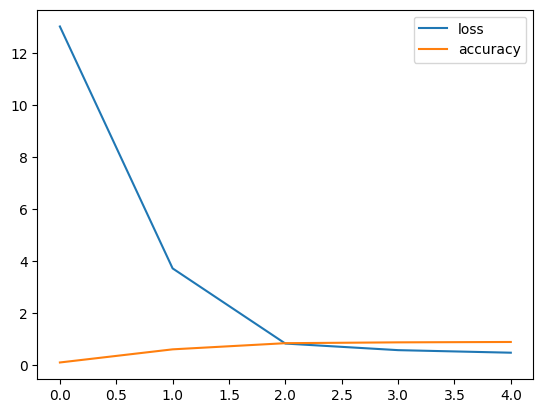

In [5]:
model.plot()

In [6]:
model.evaluate(x_train, y_train), model.evaluate(x_test, y_test), model.evaluate(x_vaild, y_vaild)

((0.4161601632297263, 0.9055666666666667),
 (0.5066179317552106, 0.8895000000000001),
 (0.2857462989893389, 0.935))